In [11]:
# !ls /root/data/processed/synthetic_cabin_bw/A_Pillar_Codriver/images/val

In [12]:
# img_name = '000000006251.jpg'
# data_split = 'train'

# # img_name = '000000003126.jpg'
# # data_split = 'val'

# # img_name = '000000042188.jpg'
# # data_split = 'test'
camera_positions = ['A_Pillar_Driver', 'Rear_Mirror', 'A_Pillar_Codriver']
camera_position = camera_positions[2]
# img_path = f'/root/data/processed/synthetic_cabin_bw/{camera_position}/images/{data_split}/{img_name}'
img_path = './tmp_img/drive_and_act.jpg'
print(img_path)

./tmp_img/drive_and_act.jpg


In [13]:
from src.modules.human_detector.human_detector import HumanDetector

detector = HumanDetector(
    config_path='./src/modules/human_detector/config/faster_rcnn.py',
    pretrained_path="https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/"\
        "faster_rcnn_r101_caffe_fpn_1x_coco/faster_rcnn_r101_caffe_fpn_1x_coco_bbox_mAP-0.398_20200504_180057-b269e9dd.pth",
    checkpoint_path="https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/"\
        "faster_rcnn_r101_caffe_fpn_1x_coco/faster_rcnn_r101_caffe_fpn_1x_coco_bbox_mAP-0.398_20200504_180057-b269e9dd.pth",
    # checkpoint_path="mmengine_workdir/human_detector/epoch_1.pth",
    data_root_path='/root/data/processed/synthetic_cabin_bw/A_Pillar_Codriver/',
    device='cuda:0',
    working_directory='./mmengine_workdir/human_detector',
    log_level='CRITICAL'
    # log_level='INFO'
)

detector.load_pretrained()
# detector.update_config()
detector_result = detector.get_bbox(img_path)
bbox = detector_result['bboxes']
print(bbox)

/opt/conda/lib/python3.10/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r101_caffe_fpn_1x_coco/faster_rcnn_r101_caffe_fpn_1x_coco_bbox_mAP-0.398_20200504_180057-b269e9dd.pth
tensor([[296.8946, 191.2596, 876.2919, 574.9462]], device='cuda:0')


In [14]:
detector_result

{'bboxes': tensor([[296.8946, 191.2596, 876.2919, 574.9462]], device='cuda:0'),
 'scores': tensor([0.9695], device='cuda:0')}

In [15]:
# bbox = np.array([[ 400,   300,  800, 850]])
bbox

tensor([[296.8946, 191.2596, 876.2919, 574.9462]], device='cuda:0')

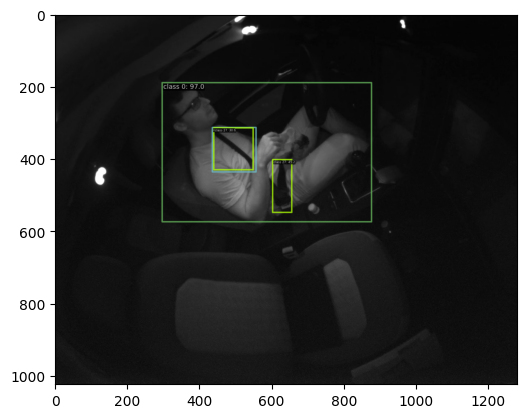

In [16]:
detector.visualise(img_path)

In [17]:
from src.modules.pose_estimator_2d.pose_estimator_2d import PoseEstimator2D
import numpy as np

pose_estimator_2d = PoseEstimator2D(
    config_path='src/modules/pose_estimator_2d/config/hrnet.py',
    pretrained_path='https://download.openmmlab.com/mmpose/v1' \
        '/body_2d_keypoint/topdown_heatmap/coco'\
            '/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth',
    # checkpoint_path="mmengine_workdir/pose_estimator_2d/best_coco_AP_epoch_0.pth",
    # checkpoint_path="mmengine_workdir/pose_estimator_2d/best_coco_AP_epoch_9.pth",
    checkpoint_path='https://download.openmmlab.com/mmpose/v1' \
        '/body_2d_keypoint/topdown_heatmap/coco'\
            '/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth',
    data_root_path='/root/data/processed/synthetic_cabin_bw/A_Pillar_Codriver/',
    device='cuda:0',
    working_directory='mmengine_workdir/pose_estimator_2d',
    log_level='CRITICAL'
)
# pose_estimator_2d.update_config()
pose_estimator_2d.load_pretrained()
pose_estimator_2d_result = pose_estimator_2d.inference(img_path, bbox.detach().cpu().numpy(), bbox_format='xywh')
# pose_estimator_2d_result = pose_estimator_2d.inference(img_path, bbox, bbox_format='xywh')
# pose_estimator_2d_result = pose_estimator_2d.inference(img_path, np.array([[0, 0, 1200, 1000]]), bbox_format='xywh')
keypoints_2D = pose_estimator_2d_result[0].pred_instances['keypoints'][0]
print(keypoints_2D)

/opt/conda/lib/python3.10/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmpose.visualization.local_visualizer.PoseLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

[[421.26407178 256.23671389]
 [409.85402107 233.4166131 ]
 [387.03391965 256.23671389]
 [421.26407178 244.82666349]
 [352.80376752 313.28696585]
 [466.90427462 324.69701624]
 [421.26407178 438.79752016]
 [581.00478172 358.92716742]
 [546.77462959 552.89802408]
 [626.64498456 358.92716742]
 [569.59473101 415.97741938]
 [649.46508598 450.20757055]
 [626.64498456 541.48797369]
 [717.92539024 256.23671389]
 [820.61584663 358.92716742]
 [911.89625231 404.56736898]
 [934.71635373 450.20757055]]


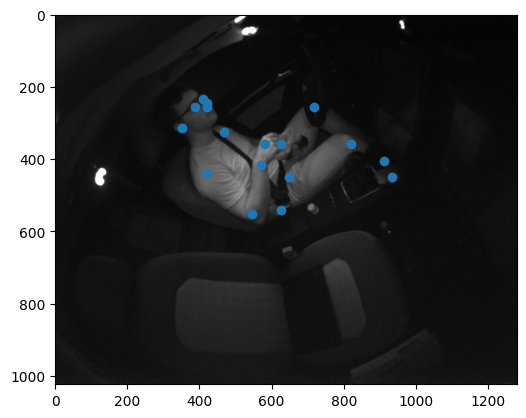

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

keypoints = pd.DataFrame(keypoints_2D, columns=['x', 'y'])

img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.scatter(keypoints['x'], keypoints['y'])

plt.show()

In [19]:
# import json
# import numpy as np
# with open(f'/root/data/processed/synthetic_cabin_bw/{camera_position}/annotations/person_keypoints_{data_split}.json') as f:
#     data = json.loads(f.readline())

# annotations = {}
# for id in range(len(data['images'])):
#     annotations[data['images'][id]['file_name']] = {
#         'keypoints': np.array(data['annotations'][id]['keypoints']).reshape(-1, 3)[:, :2]
#     }

In [20]:
pose_estimator_2d.visualize(
    img_path=img_path,
    bboxes=bbox.tolist(),
    bbox_format='xywh',
    gt_keypoints=np.expand_dims(annotations[img_name]['keypoints'], 0)
)

NameError: name 'annotations' is not defined